### Bibliotheken importieren

In [309]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

## 1. Datenexploration

### Daten laden

In [310]:
df = pd.read_csv('./data/windmill_data.csv')

print("Allgemeine Informationen:")
print(df.info())

Allgemeine Informationen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53093 entries, 0 to 53092
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   turbine_id              53093 non-null  object 
 1   timestamp               53093 non-null  object 
 2   turbine_type            53093 non-null  object 
 3   maintenance_team        53093 non-null  object 
 4   wind_speed_ms           53093 non-null  float64
 5   wind_direction          53093 non-null  object 
 6   power_output_kw         53093 non-null  float64
 7   vibration_mm_s          52032 non-null  float64
 8   temperature_c           52563 non-null  float64
 9   hydraulic_pressure_bar  53093 non-null  float64
 10  days_since_maintenance  53093 non-null  int64  
 11  failure_risk_30d        53093 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 4.9+ MB
None


In [311]:
print("Die verfügbaren Spalten:")
print(df.columns)

Die verfügbaren Spalten:
Index(['turbine_id', 'timestamp', 'turbine_type', 'maintenance_team',
       'wind_speed_ms', 'wind_direction', 'power_output_kw', 'vibration_mm_s',
       'temperature_c', 'hydraulic_pressure_bar', 'days_since_maintenance',
       'failure_risk_30d'],
      dtype='object')


In [312]:
print("Die ersten Zeilen des Datensatzes:")
print(df.head())

Die ersten Zeilen des Datensatzes:
  turbine_id            timestamp turbine_type maintenance_team  \
0       T001  2022-01-01 00:00:00   Vestas V90           Team_B   
1       T001  2022-01-01 04:00:00   Vestas V90           Team_B   
2       T001  2022-01-01 08:00:00   Vestas V90           Team_B   
3       T001  2022-01-01 12:00:00   Vestas V90           Team_B   
4       T001  2022-01-01 16:00:00   Vestas V90           Team_B   

   wind_speed_ms wind_direction  power_output_kw  vibration_mm_s  \
0          11.45             SE           1562.2           0.750   
1          15.11              W           1800.0           0.774   
2          14.30             SW           1800.0           0.885   
3          15.55              W           1800.0           0.005   
4          10.88              W           1340.6           1.248   

   temperature_c  hydraulic_pressure_bar  days_since_maintenance  \
0           58.0                   182.3                     106   
1           63.4 

In [313]:
print("Statistische Zusammenfassung:")
print(df.describe())

Statistische Zusammenfassung:
       wind_speed_ms  power_output_kw  vibration_mm_s  temperature_c  \
count   53093.000000     53093.000000    52032.000000   52563.000000   
mean       10.624950      1690.621101        1.529983      73.448443   
std         3.442334      1534.366938        0.928547      12.513317   
min         0.000000         0.000000        0.000000      31.700000   
25%         8.250000       661.600000        0.920000      64.600000   
50%        10.630000      1479.700000        1.416000      72.200000   
75%        12.980000      1800.000000        1.984000      81.000000   
max        57.830000      6000.000000        8.823000     130.500000   

       hydraulic_pressure_bar  days_since_maintenance  failure_risk_30d  
count            53093.000000            53093.000000      53093.000000  
mean               169.225329               33.631232          0.009794  
std                 11.514948               23.185967          0.098480  
min                133.10

In [314]:
print("Anzahl fehlender Werte:")
print(df.isnull().sum())

print("\nAnzahl fehlender Werte insgesamt:")
print(df.isnull().sum().sum())

Anzahl fehlender Werte:
turbine_id                   0
timestamp                    0
turbine_type                 0
maintenance_team             0
wind_speed_ms                0
wind_direction               0
power_output_kw              0
vibration_mm_s            1061
temperature_c              530
hydraulic_pressure_bar       0
days_since_maintenance       0
failure_risk_30d             0
dtype: int64

Anzahl fehlender Werte insgesamt:
1591


In [315]:
print(df['failure_risk_30d'].value_counts())

failure_risk_30d
0    52573
1      520
Name: count, dtype: int64


hier ist es sinnvoll nach "failure_risk_30d" zu klassifizieren, da man so anhand der anderen Daten einschätzen kann, ob es einen Ausfall gibt. In den Daten gibt es entweder 0 oder 1. Daraus folgt, dass zwischen 0 und 1 klassifiziert werden sollte. "temperature_c" und "vibration_mm_s" haben fehlende Werte, die beachtet werden sollten.

## 2. Datenaufbereitung

### Durchführung notwendiger Transformationen

In [316]:
# unnötige Spalten entfernen
X = df.drop(['failure_risk_30d', 'timestamp', 'turbine_id'], axis=1)
# Zielvariable definieren
y = df['failure_risk_30d']

X.info()
# Löschen fehlender Werte
X = X.dropna(subset=['vibration_mm_s', 'temperature_c'])
X.info()

# Sicherstellen dass y die gleiche Länge wie x hat
y = y.loc[X.index]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53093 entries, 0 to 53092
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   turbine_type            53093 non-null  object 
 1   maintenance_team        53093 non-null  object 
 2   wind_speed_ms           53093 non-null  float64
 3   wind_direction          53093 non-null  object 
 4   power_output_kw         53093 non-null  float64
 5   vibration_mm_s          52032 non-null  float64
 6   temperature_c           52563 non-null  float64
 7   hydraulic_pressure_bar  53093 non-null  float64
 8   days_since_maintenance  53093 non-null  int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 51514 entries, 0 to 53092
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   turbine_type            51514 non

### Aufteilung von Trainings- und Testdaten und verwenden eines Random-States

In [317]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### weitere Transformationen

In [318]:
# encoding
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# gleichmäßige Aufteilung der Klassen
smote = SMOTE(random_state=42)

X_train_processed, y_train = smote.fit_resample(X_train_processed, y_train)


## 3. Modelltraining

### Logistische Regression

In [319]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_processed, y_train)
y_pred_lr = lr.predict(X_test_processed)

### Decision Tree

In [320]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_processed, y_train)
y_pred_dt = dt.predict(X_test_processed)

### KNN

In [321]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_processed, y_train)
y_pred_knn = knn.predict(X_test_processed)

### Random Forest

In [322]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)
y_pred_rf = rf.predict(X_test_processed)

## 3.5 Ensemble Learning

### Bagging

In [323]:
bagging = BaggingClassifier(estimator=dt, random_state=42)
bagging.fit(X_train_processed, y_train)
y_pred_bag = bagging.predict(X_test_processed)

### Gradient Boosting

In [324]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_processed, y_train)
y_pred_gradboost = gb.predict(X_test_processed)

## 4. Modellbewertung

### Klassifikationsbericht

In [325]:
def print_classification_report(y_pred, title):
    print(f"\033[92m{title}\033[0m Modellbewertung:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nKlassifikationsbericht:")
    print(classification_report(y_test, y_pred, zero_division=0))

# übersichtliche Tabelle der Ergebnisse
print_classification_report(y_pred_lr, "Logistische Regression")
print_classification_report(y_pred_dt, "Decision Tree")
print_classification_report(y_pred_knn, "KNN")
print_classification_report(y_pred_rf, "Random Forest")
print_classification_report(y_pred_bag, "Bagging")
print_classification_report(y_pred_gradboost, "Gradient Boosting")

Logistische Regression Modellbewertung:
Accuracy: 0.7365

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85     10202
           1       0.03      0.89      0.06       101

    accuracy                           0.74     10303
   macro avg       0.52      0.81      0.45     10303
weighted avg       0.99      0.74      0.84     10303

Decision Tree Modellbewertung:
Accuracy: 0.9759

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10202
           1       0.16      0.34      0.22       101

    accuracy                           0.98     10303
   macro avg       0.58      0.66      0.60     10303
weighted avg       0.99      0.98      0.98     10303

KNN Modellbewertung:
Accuracy: 0.9554

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10202
           1       

### Konfusionsmatrix

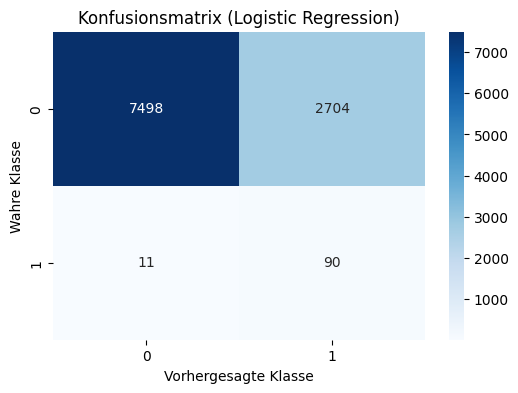

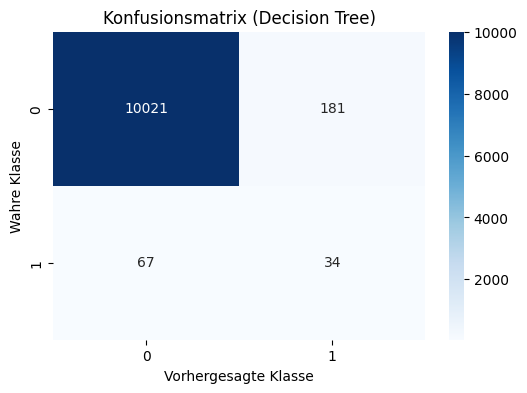

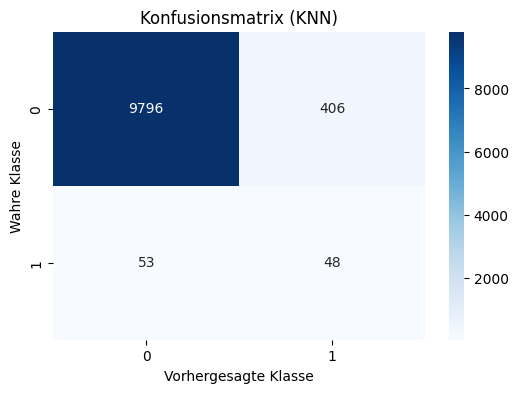

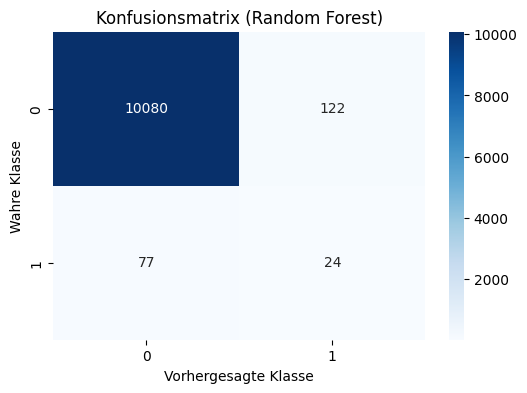

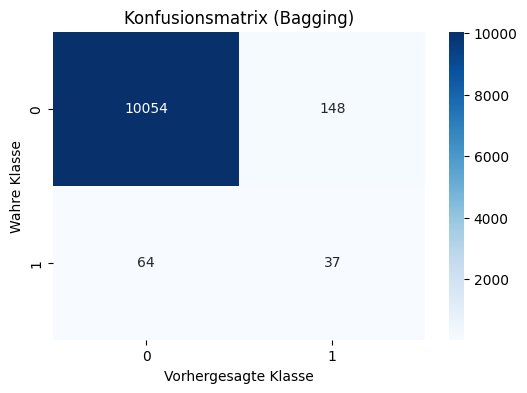

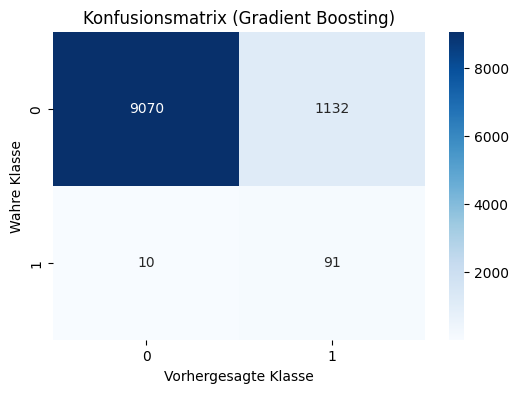

In [326]:
def plot_confusion_matrix(y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Wahre Klasse')
    plt.title(f'Konfusionsmatrix ({title})')
    plt.show()

# plotten als Konfusionsmatrizen
plot_confusion_matrix(y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_pred_dt, "Decision Tree")
plot_confusion_matrix(y_pred_knn, "KNN")
plot_confusion_matrix(y_pred_rf, "Random Forest")
plot_confusion_matrix(y_pred_bag, "Bagging")
plot_confusion_matrix(y_pred_gradboost, "Gradient Boosting")

## 5. Vergleich und Analyse

Durch die unausgeglichenen Klassen ist eine hohe Accuracy unbedeutend, da diese sehr hoch sein kann, wenn nur die Klasse mit den meisten Elementen als TP erkannt wird während die zweite Klasse falsch erkannt wird. Es wurde versucht durch `smote.fit_resample(X_train_processed, y_train)` und `stratify=y` die Klassen besser auszugleichen, was zwar zu etwas besseren, aber keinen guten rgebnissen geführt hat.

Recall ist in einem realen Szenario wichtiger als die Precision, da bei Windmills FPs fataler sind als FNs. FNs bedeuten, dass etwas kaputt ist, was aber nicht entdeckt wird. Weniger schlimm ist, dass Windmills kontrolliert werden, die gar nicht kaputt sind, auch, wenn das trotzdem den Arbeitsaufwand erhöht und so gut wie möglich vermieden werden sollte.

Da der F1-Score Precision und Recall kombiniert, sollte dieser auch möglichst hoch sein, jedoch ist in der realen Anwendung der Recall vermutlich viel wichtiger.

Den größten Recall haben Logistic Regression und Gradient Boosting. Zudem hat Gradient Boosting einer höhere Präzision und somit einen höheren F1-Score, weshalb sich das am besten für diesen Anwendungsfall eignet. Wenn mehr auf das Gleichgewicht zwischen Recall und Precision geachtet werden sollte, dann sollte Bagging verwendet werden, da hier der beste F1-Score vorliegt. Für alle Ansätze wäre es vermutlich besser, wenn ausgeglichenere Ausgangsdaten präsent wären.

| Modell           | Accuracy | Precision (1) | Recall (1) | F1 (1) | Notiz |
|------------------|----------|---------------|------------|--------|-----------|
| **Logistic Regression** | 0.7365   | 0.03         | 0.89  | 0.06  | mehr FPs als Gradient Boosting |
| **Decision Tree**   | 0.9759   | 0.16         | 0.34      | 0.22  | ausgeglichen, aber allgemein niedrige Werte |
| **KNN**             | 0.9554   | 0.11         | 0.48      | 0.17  | besserer Recall, aber nicht so gut wie LR und GB |
| **Random Forest**   | 0.9807 | 0.16     | 0.24      | 0.19 | ausgeglichen, aber allgemein niedrige Werte |
| **Bagging**         | 0.9794   | 0.20         | 0.37 | 0.26  | Bester F1-Score, aber im Vergleich schlechter Recall, höhere Gefahr |
| **Gradient Boosting**         | 0.8892   | 0.07         | 0.90   | 0.14  | höchster Recall, aber geringe Präzision, viele FPs |